In [1]:
2+2

4

In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

from collections import namedtuple

from pa_lib.file import (
    store_bin,
    project_dir,
    data_files,
    load_csv,
    load_bin,
    write_xlsx,
)
from pa_lib.data import as_dtype, dtFactor, desc_col, lookup, clean_up_categoricals
from pa_lib.util import collect, value, flatten, normalize_rows, list_items
from pa_lib.log import time_log
from pa_lib.types import Record

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Load data

In [4]:
with project_dir("axinova"):
    ax_data = load_bin("ax_data.feather")
    ax_var_struct = load_bin("ax_var_struct.feather")

with time_log("merging code numbers to data"):
    ax_data["Label_Nr"] = lookup(
        target_df=ax_var_struct,
        target_col_name="Label_Nr",
        match_col=ax_data[["Variable", "Code"]],
        target_match_col_name=["Variable", "Label"],
    )

11:29:52 [INFO] Started loading binary file
11:29:52 [INFO] Reading from file C:\Users\stc\data\axinova\ax_data.feather
11:29:53 [INFO] Finished loading binary file in 0.14s (0.53s CPU)
11:29:53 [INFO] Started loading binary file
11:29:53 [INFO] Reading from file C:\Users\stc\data\axinova\ax_var_struct.feather
11:29:53 [INFO] Finished loading binary file in 0.0s (0.0s CPU)
11:29:53 [INFO] Started merging code numbers to data
11:30:07 [INFO] Finished merging code numbers to data in 14.18s (15.11s CPU)


In [5]:
Variable = namedtuple("Variable", ["Label", "Codes", "Order"])

var_info = {}
for var, data in ax_var_struct.groupby("Variable"):
    var_info[var] = Variable(data["Variable_Label"].max(), data["Label"].to_list(), data["Label_Nr"].to_list())

### Variable/Code table for output

In [6]:
var_info_tab = pd.DataFrame.from_records(
    columns=["Variable", "Label", "Codes", "Order"],
    data=[
        (var, var_info[var].Label, ",".join(var_info[var].Codes), ",".join(map(str, var_info[var].Order))) for var in var_info
    ],
    index="Variable",
)

In [7]:
with project_dir("axinova"):
    write_xlsx(var_info_tab, "variable_info.xlsx", sheet_name="Variables")

11:31:20 [INFO] Started writing xlsx file
11:31:20 [INFO] Writing to file C:\Users\stc\data\axinova\variable_info.xlsx
11:31:20 [INFO] Written 11.2 KB
11:31:20 [INFO] Finished writing xlsx file in 0.1s (0.05s CPU)


In [8]:
def var_label(variable):
    return var_info[variable].Label


def var_codes(variable):
    return var_info[variable].Codes

In [9]:
weekday_order = ax_data["DayOfWeek"].cat.categories.to_list()
workdays = weekday_order[:5]
weekend = weekday_order[5:]
ax_data["is_weekend"] = ax_data["DayOfWeek"].isin(weekend)

timeSlot_order = ax_data["TimeSlot"].cat.categories.to_list()
day = timeSlot_order[1:]
rush_hours = list_items(timeSlot_order, [1, 5])
day_no_rush = list_items(timeSlot_order, [2, 3, 4, 6])
ax_data["is_day"] = ax_data["TimeSlot"].isin(day)
ax_data["is_rush"] = ax_data["TimeSlot"].isin(rush_hours)
ax_data["is_day_no_rush"] = ax_data["TimeSlot"].isin(day_no_rush)

ax_data.loc[ax_data["is_rush"], "TimeSlot_cat"] = "Day: Rush Hours"
ax_data.loc[ax_data["is_day_no_rush"], "TimeSlot_cat"] = "Day: no Rush Hours"
ax_data["TimeSlot_cat"].fillna("Night", inplace=True)

stations_d = [
    "Aarau",
    "Basel SBB",
    "Bern",
    "Biel/Bienne",
    "Brig",
    "Chur",
    "Luzern",
    "Olten",
    "St. Gallen",
    "Winterthur",
    "Zug",
    "Zürich Enge",
    "Zürich Flughafen",
    "Zürich Flughafen - Airside",
    "Zürich Flughafen - Landside",
    "Zürich HB",
    "Zürich Hardbrücke",
    "Zürich Oerlikon",
    "Zürich Stadelhofen",
]
stations_f = [
    "Biel/Bienne",
    "Fribourg",
    "Genève Aéroport",
    "Genève Cornavin",
    "Lausanne",
    "M2",
    "Neuchatel",
]
stations_i = ["Bellinzona", "Lugano"]
ax_data.loc[ax_data["Station"].isin(stations_f), "StationSprache"] = "Französisch"
ax_data.loc[ax_data["Station"].isin(stations_i), "StationSprache"] = "Italienisch"
ax_data.loc[ax_data["Station"].isin(stations_d), "StationSprache"] = "Deutsch"

ax_data = as_dtype(ax_data, dtFactor, incl_dtype=["bool", "object"])

In [10]:
with value(ax_data["DayOfWeek"].isin(weekend)) as weekend_rows:
    ax_data_weekends = ax_data.loc[weekend_rows].pipe(clean_up_categoricals).reset_index(drop=True)
    ax_data_workdays = ax_data.loc[~weekend_rows].pipe(clean_up_categoricals).reset_index(drop=True)

In [11]:
desc_col(ax_data, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/7739206,27,7.4 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/7739206,7,7.4 MB,"[Monday,Sunday]"
Time,category,0/7739206,96,7.4 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/7739206,117,7.4 MB,"[g_220,nat_ausland]"
Code,category,0/7739206,156,14.8 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/7739206,423653,59.0 MB,"[0.47903999999999997,58.059993773]"
Year,category,0/7739206,1,7.4 MB,"[2019,2019]"
Month,category,0/7739206,5,7.4 MB,"[05,09]"
logValue,float64,0/7739206,423653,59.0 MB,"[-0.7359711777508736,4.0614768513453585]"
VarDesc,category,0/7739206,117,7.4 MB,"[Abteilungs-/Teamleitung,kein Mobiltelefon]"


In [12]:
desc_col(ax_data_workdays, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/5652746,27,5.4 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/5652746,5,5.4 MB,"[Monday,Friday]"
Time,category,0/5652746,96,5.4 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/5652746,117,5.4 MB,"[g_220,nat_ausland]"
Code,category,0/5652746,155,10.8 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/5652746,359475,43.1 MB,"[0.47903999999999997,58.059993773]"
Year,category,0/5652746,1,5.4 MB,"[2019,2019]"
Month,category,0/5652746,5,5.4 MB,"[05,09]"
logValue,float64,0/5652746,359475,43.1 MB,"[-0.7359711777508736,4.0614768513453585]"
VarDesc,category,0/5652746,117,5.4 MB,"[Abteilungs-/Teamleitung,kein Mobiltelefon]"


In [13]:
desc_col(ax_data_weekends, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/2086460,27,2.0 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/2086460,2,2.0 MB,"[Saturday,Sunday]"
Time,category,0/2086460,96,2.0 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/2086460,117,2.0 MB,"[g_220,nat_ausland]"
Code,category,0/2086460,155,4.0 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/2086460,93565,15.9 MB,"[0.47903999999999997,30.32099024]"
Year,category,0/2086460,1,2.0 MB,"[2019,2019]"
Month,category,0/2086460,5,2.0 MB,"[05,09]"
logValue,float64,0/2086460,93565,15.9 MB,"[-0.7359711777508736,3.4118402198714635]"
VarDesc,category,0/2086460,117,2.0 MB,"[Abteilungs-/Teamleitung,kein Mobiltelefon]"


# Check distributions

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

## Time

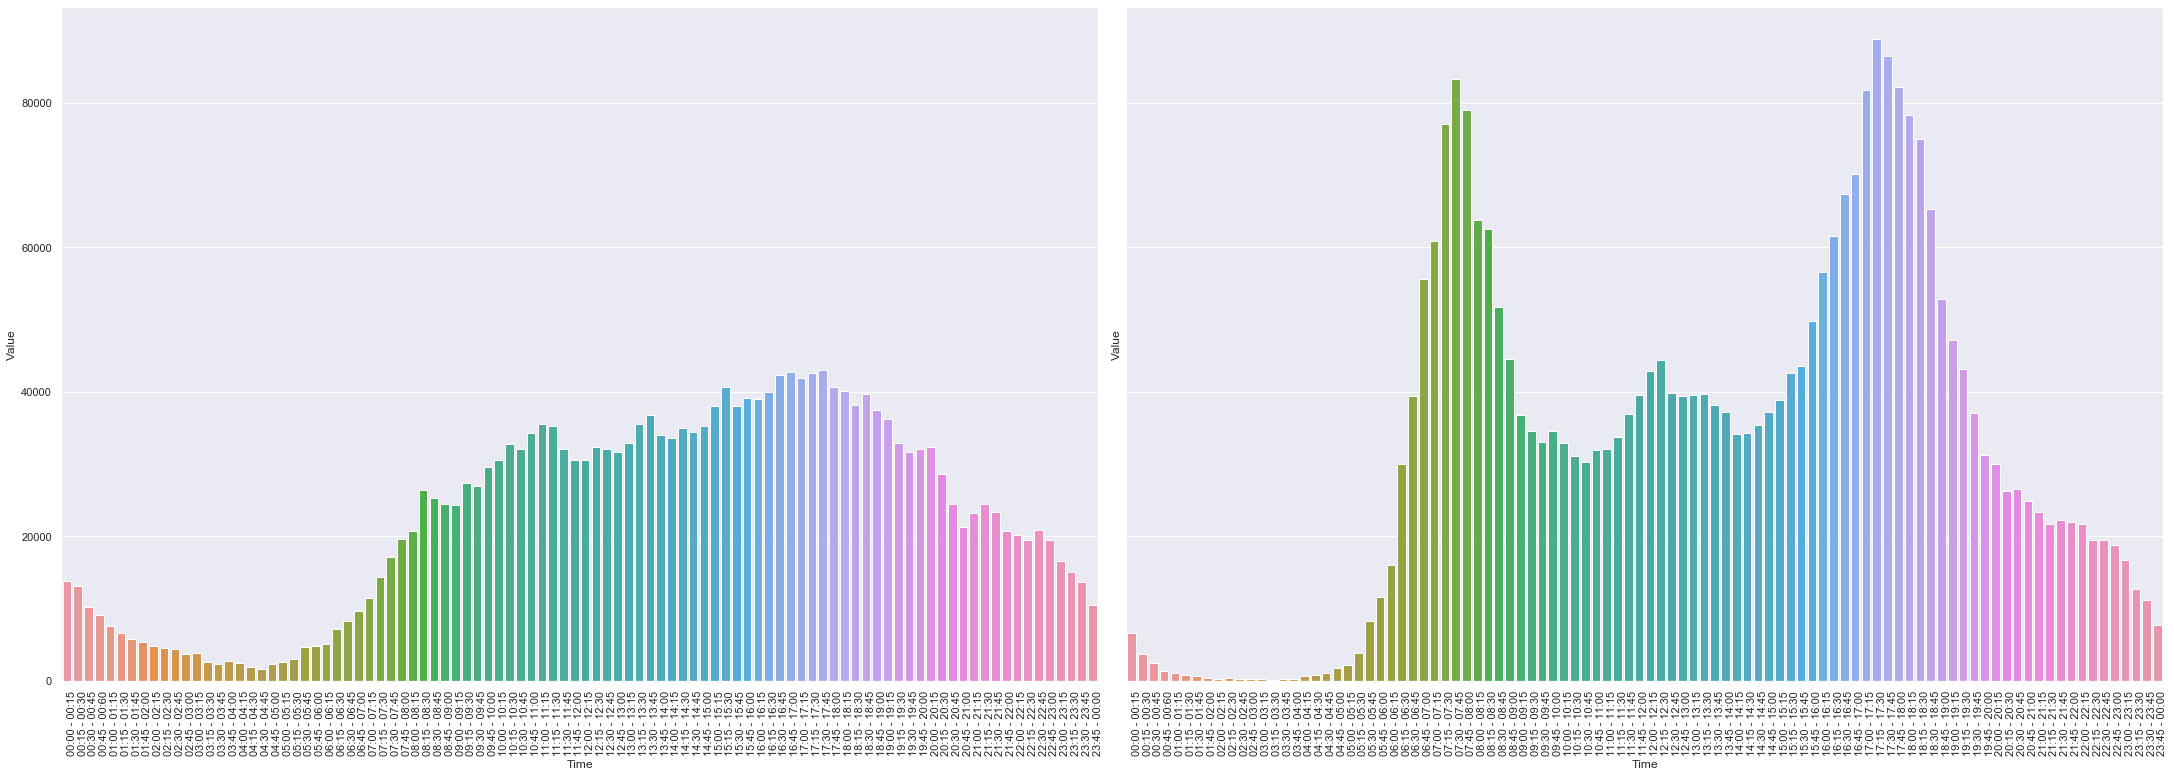

In [15]:
fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=1, ncols=2, sharey="all", figsize=(30, 12)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"), # average weekend day
    x="Time",
    y="Value",
    ci=None,
    estimator=np.sum,
    ax=ax_weekend,
)
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"), # average workday
    x="Time",
    y="Value",
    ci=None,
    estimator=np.sum,
    ax=ax_workdays,
)
fig.autofmt_xdate(rotation=90, ha="left")

### Time by Weekday

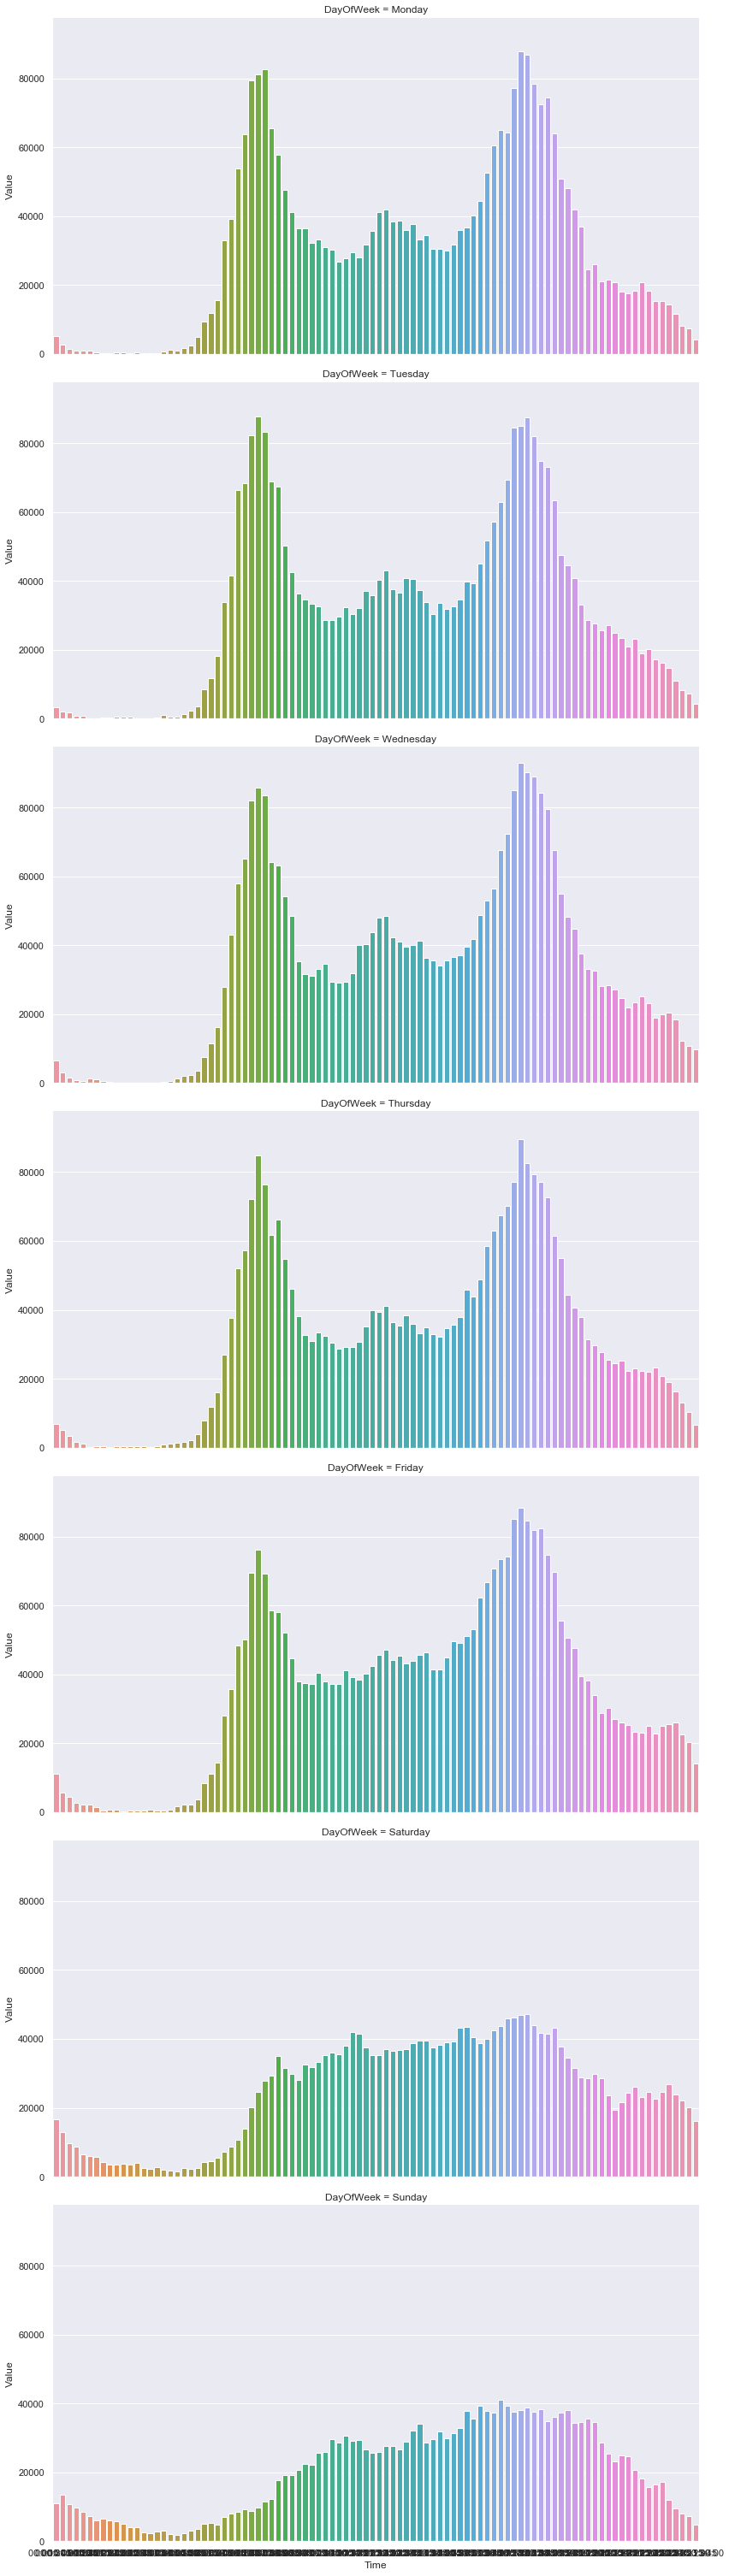

In [16]:
sns.catplot(
    data=ax_data,
    kind="bar",
    x="Time",
    y="Value",
    row="DayOfWeek",
    row_order=weekday_order,
    ci=None,
    estimator=np.sum,
    height=6,
    aspect=2,
)

## Hours

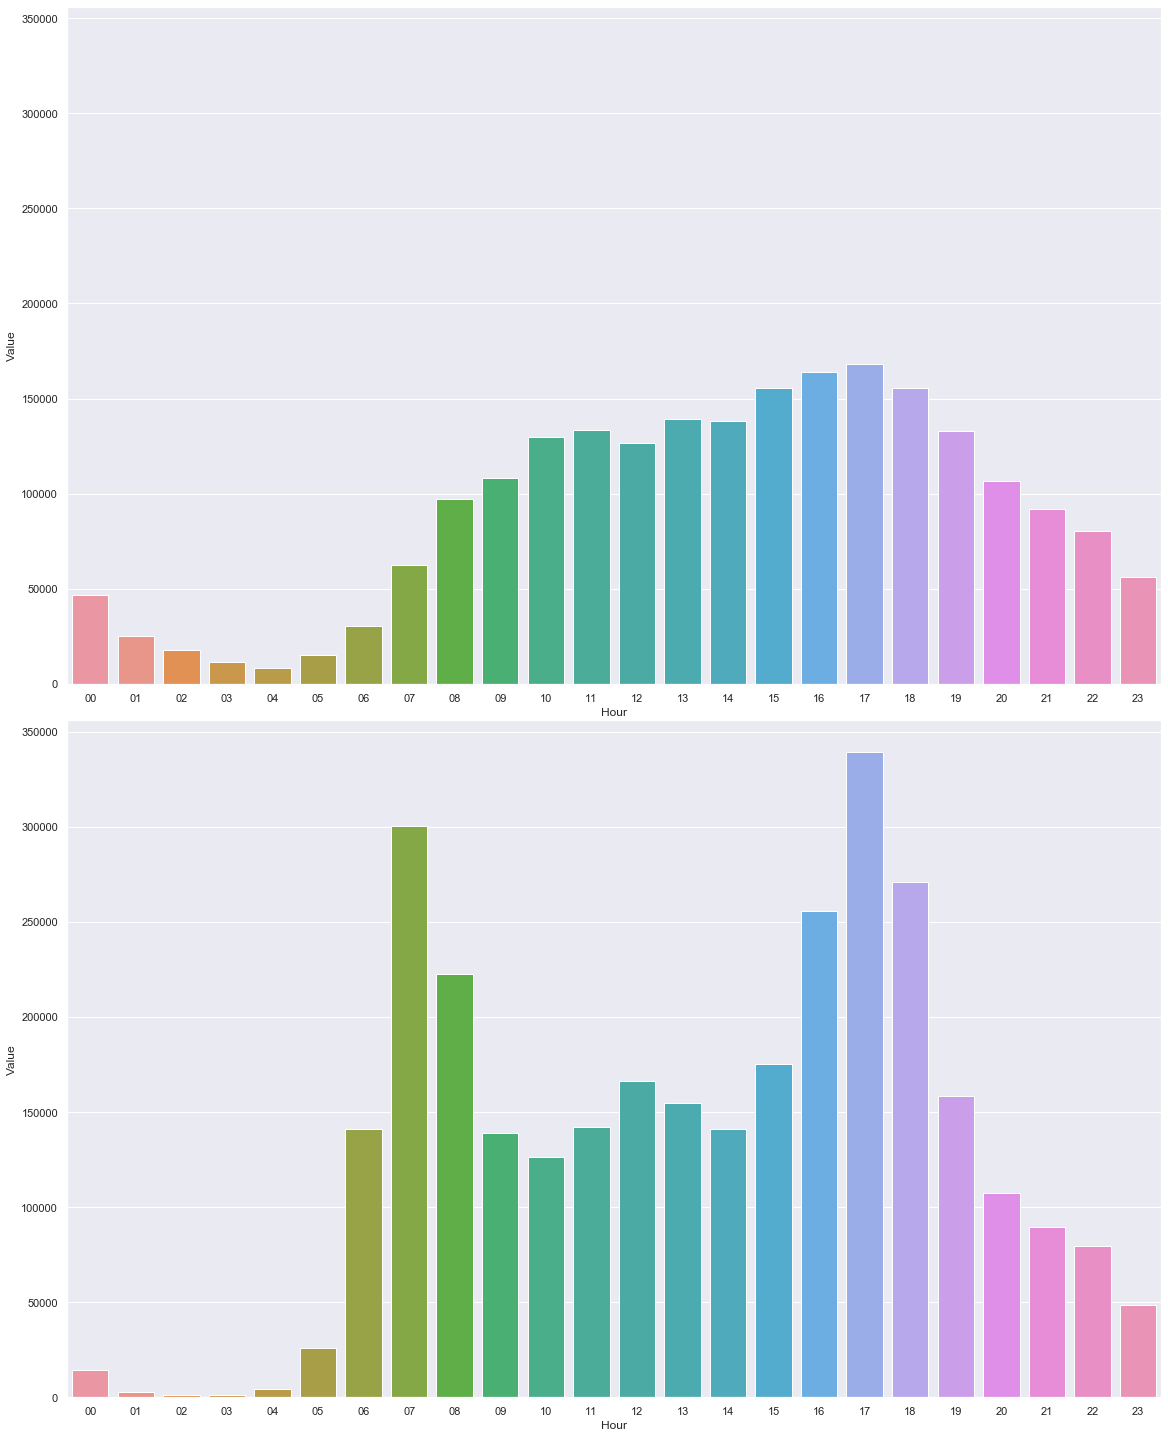

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(16, 20)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),  # average workday
    x="Hour",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_workdays,
)
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),  # average weekend day
    x="Hour",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_weekend,
)

## Time Slots

In [18]:
ax_data["TimeSlot"].value_counts()

Abend-Rush     1570957
Abend          1397926
Nachmittag     1342158
Morgen-Rush    1178269
Mittag          863201
Morgen          815176
Nacht           571519
Name: TimeSlot, dtype: int64

### Plot sum(value) per time slot, scaled to one day

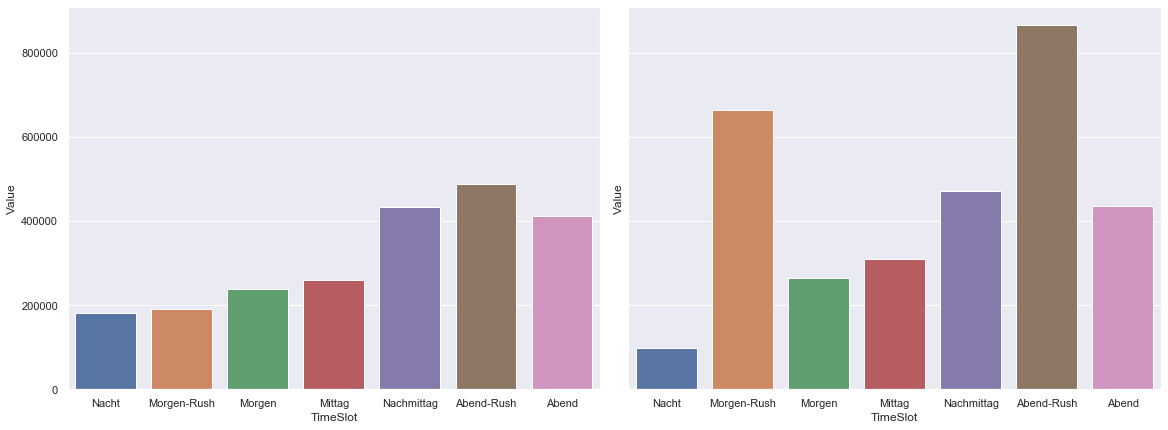

In [19]:
fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=1, ncols=2, sharey="all", figsize=(16, 6)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_weekend,
)
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_workdays,
)

In [20]:
ax_data.groupby("TimeSlot").agg({"Hour": collect})

,Hour
TimeSlot,
Nacht,"00,01,02,03,04,05,23"
Morgen-Rush,"06,07,08"
Morgen,"09,10"
Mittag,"11,12"
Nachmittag,"13,14,15"
Abend-Rush,"16,17,18"
Abend,"19,20,21,22"


## Stations

In [21]:
ax_data.Station.value_counts()

Zürich HB                      603304
Bern                           487248
Lausanne                       403885
Zürich Stadelhofen             398022
Basel SBB                      381001
Zürich Hardbrücke              364750
Zürich Oerlikon                357811
Luzern                         354994
Winterthur                     345554
Olten                          337989
Genève Cornavin                323205
Aarau                          312328
Fribourg                       311089
Biel/Bienne                    301224
Lugano                         296779
Zug                            292876
St. Gallen                     279608
Zürich Flughafen               229545
Genève Aéroport                212946
Bellinzona                     184104
Neuchatel                      182475
Zürich Enge                    164347
Chur                           142932
Brig                           126636
Zürich Flughafen - Landside    117521
Zürich Flughafen - Airside     117286
M2          

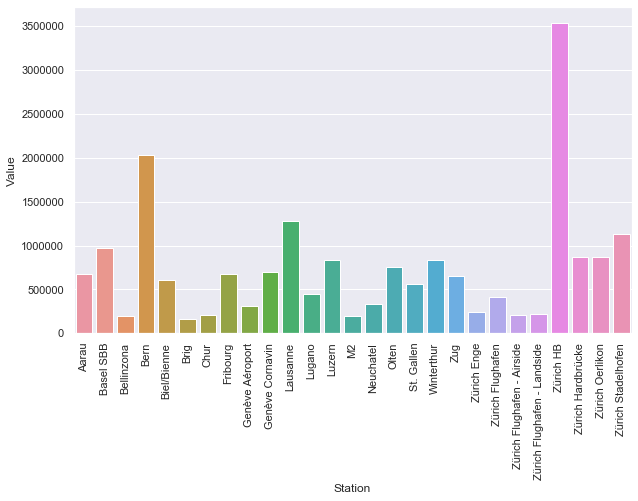

In [22]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)

sns.barplot(data=ax_data, x="Station", y="Value", ci=None, estimator=np.sum)

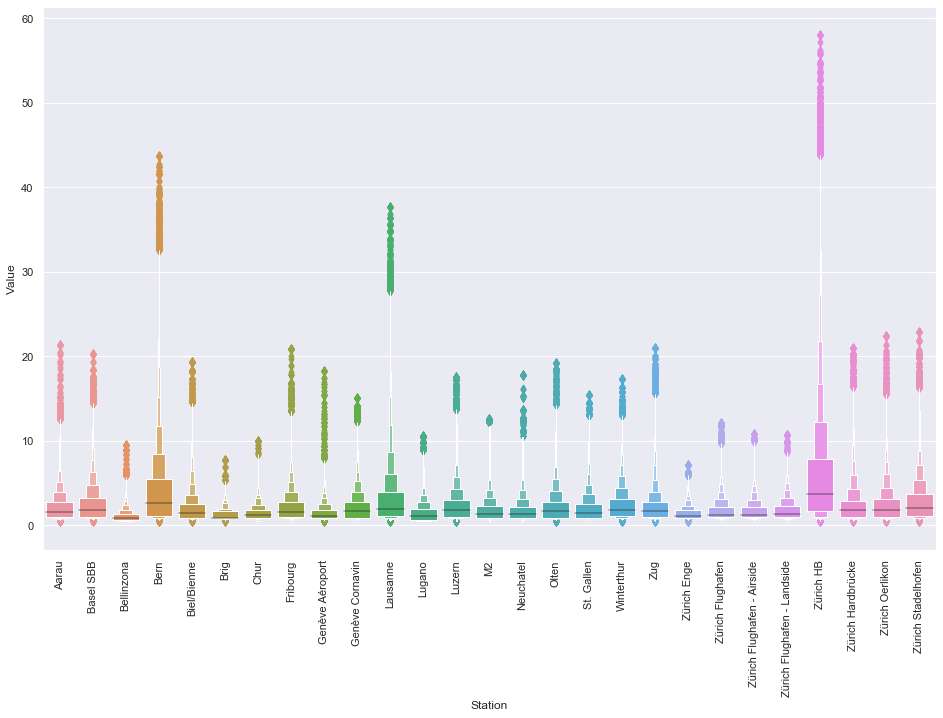

In [23]:
plt.figure(figsize=(16, 10))
plt.xticks(rotation=90)

sns.boxenplot(data=ax_data, x="Station", y="Value")

## Weekdays

In [24]:
ax_data.DayOfWeek.value_counts()

Friday       1229354
Wednesday    1137455
Thursday     1113459
Saturday     1104354
Tuesday      1093580
Monday       1078898
Sunday        982106
Name: DayOfWeek, dtype: int64

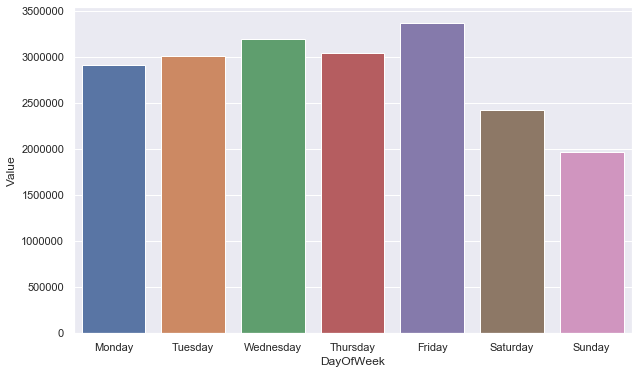

In [25]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=ax_data,
    x="DayOfWeek",
    y="Value",
    ci="sd",
    estimator=np.sum,
    order=weekday_order,
)

## Months

In [26]:
ax_data.Month.value_counts()

08    1593196
09    1566471
05    1537462
07    1531483
06    1510594
Name: Month, dtype: int64

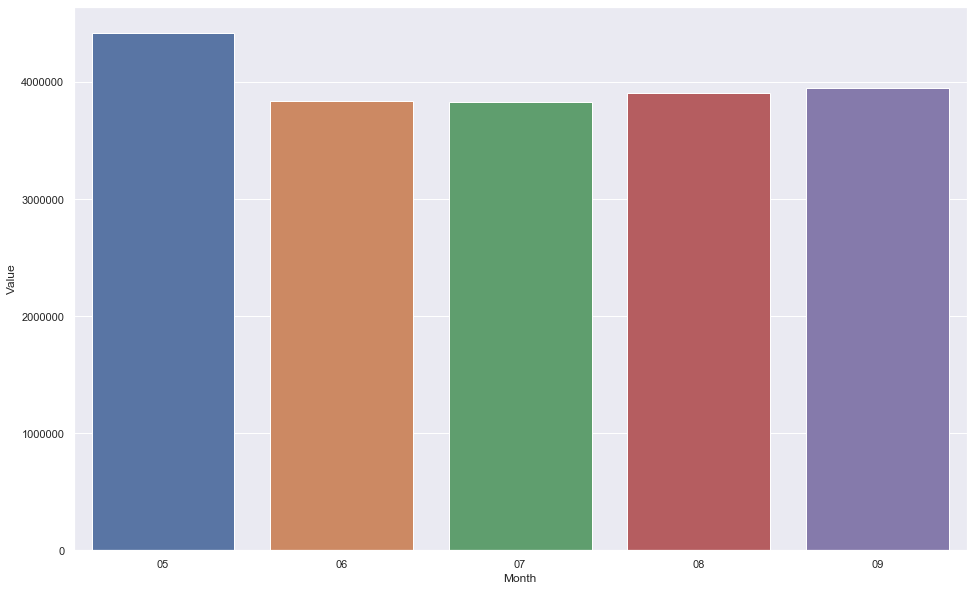

In [27]:
plt.figure(figsize=(16, 10))

sns.barplot(
    data=ax_data,
    x="Month",
    y="Value",
    estimator=np.sum,
    ci=None
);

## Variables (Questions)

In [28]:
ax_data.Variable.value_counts()

md_ek                130137
md_880               127606
md_hhverm            121704
md_agenatrep         111664
md_gebiet            110516
g_TvChannelsgroup    110131
md_403               109514
md_203               109420
md_kanton            108784
g_privatetrainuse    108363
md_hhgr3              99988
g_flug                99600
g_220                 99566
md_416                99329
md_early              98675
md_zivil              94447
md_417                92660
md_419                91988
md_414                91519
md_413                90935
md_bildung3           90635
md_411                85735
md_berufgroup         85660
md_region             83667
md_sex                83428
g_sportSingle         83297
g_CarMedium           83077
g_500                 82918
md_swisscom           82655
g_SwissPrivateTv      82639
md_wohneigentum       82241
md_382                79700
nat_ausland           78465
md_standort           78068
md_412                77853
g_ForeignTv         

NameError: name 'select_data' is not defined

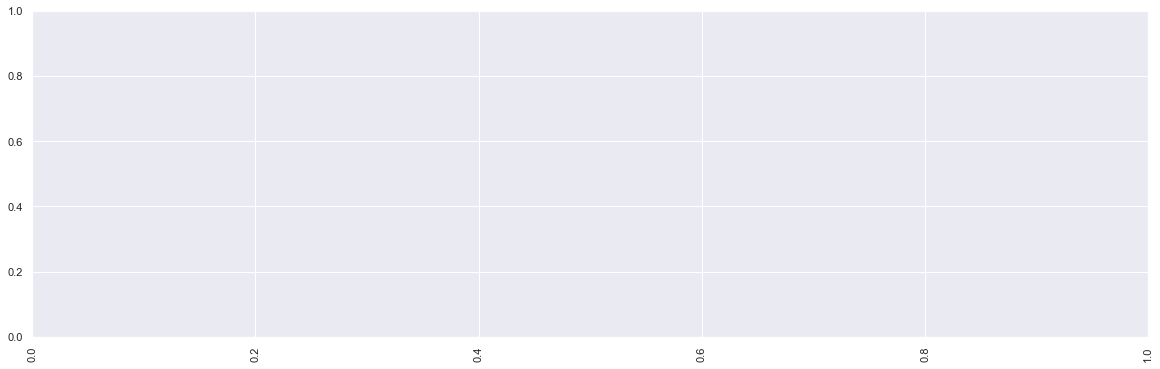

In [29]:
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)

sns.barplot(
    data=select_data(
        ax_data,
        Month="09",
        DayOfWeek="Monday",
        Station="Zürich HB",
        Time="21:00 - 21:15",
    ),
    x="Variable",
    y="Value",
    estimator=np.sum,
    ci=None,
)

# Tests for Independence

In [ ]:
from scipy.stats import chi2_contingency


def var_factor_dependance(data, variable, factor, partitions):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    result = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for label, partition in subset.groupby(partitions, observed=True):
        result_row = {"Var": variable, "Label": label}
        contingency_tab = partition.pivot_table(
            index="Code", columns=factor, aggfunc="size", fill_value=0, observed=True
        )
        p_factor = chi2_contingency(contingency_tab)[1]
        result_row[f"p_{factor}"] = p_factor
        result = result.append(result_row, ignore_index=True, sort=False)
    return result


def factor_dependance(data, factor, partitions):
    all_var_assoc = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for v in var_info.keys():
        var_assoc = var_factor_dependance(
            data=data, variable=v, factor=factor, partitions=partitions
        ).query(f"p_{factor} <= 0.05")
        all_var_assoc = all_var_assoc.append(var_assoc, ignore_index=True, sort=False)
    all_var_assoc["VarDesc"] = all_var_assoc["Var"].apply(var_label)
    return all_var_assoc

## For all variables, find stations where the distribution of codes is dependent on day time / time slot

In [ ]:
%%time
# around 1min 40sec
all_var_assoc_time = factor_dependance(
    data=ax_data, factor="Time", partitions=["Station"]
)
all_var_assoc_timeslot = factor_dependance(
    data=ax_data, factor="TimeSlot", partitions=["Station"]
)

In [ ]:
var_stations_time = pd.crosstab(
    index=all_var_assoc_time["VarDesc"].str.cat(all_var_assoc_time["Var"], sep=" [")
    + "]",
    columns=all_var_assoc_time["Label"],
    margins=True,
)

with project_dir("axinova"):
    write_xlsx(
        var_stations_time, "var_by_station_vs_time.xlsx", sheet_name="contigency tab"
    )

In [ ]:
var_stations_timeslot = pd.crosstab(
    index=all_var_assoc_timeslot["VarDesc"].str.cat(
        all_var_assoc_timeslot["Var"], sep=" ["
    ) + ']',
    columns=all_var_assoc_timeslot["Label"],
    margins=True,
)

with project_dir("axinova"):
    write_xlsx(
        var_stations_timeslot,
        "var_by_station_vs_timeslot.xlsx",
        sheet_name="contigency tab",
    )

### Which variables have the most stations where their codes are time-dependent?

In [ ]:
all_var_assoc_time.groupby("Var", as_index=False).agg(
    {"VarDesc": "max", "Label": ["count", collect]}
).set_axis(
    ["Variable", "VarDesc", "#", "Stations"], axis="columns", inplace=False
).sort_values(
    "#", ascending=False
).set_index(
    "Variable"
)

### Which stations have the most variables whose codes are time-dependent?

In [ ]:
all_var_assoc_time.groupby("Label", as_index=False).agg(
    {"Var": ["size", collect]}
).set_axis(["Station", "#", "Variables"], axis="columns", inplace=False).sort_values(
    "#", ascending=False
).set_index(
    "Station"
)

## For a single variable, show distribution of codes over time

In [ ]:
import altair as alt

alt.data_transformers.enable("default", max_rows=None)

time_order = {"DayOfWeek": weekday_order, "TimeSlot": timeSlot_order}


def plot_var_time_dist(data, var, over, station, as_percent=False):
    subset = (
        data.query("Station == @station and Variable == @var")
        .pipe(clean_up_categoricals)
        .copy()
    )
    chart = (
        alt.Chart(subset)
        .mark_bar()
        .encode(
            x=alt.X("sum(Value)", stack="normalize") if as_percent else "sum(Value)",
            y=alt.Y(over, sort=time_order.get(over, "ascending")),
            color=alt.Color(
                "Code", scale=alt.Scale(scheme="spectral"), sort=var_info[var].Codes
            ),
            order=alt.Order("Label_Nr"),
        )
        .configure_view(width=800)
        .properties(
            title=f"{var_label(var)} | {over} [{station}]"
            + (", Prozent" if as_percent else "")
        )
    )
    return chart

In [ ]:
plot_var_time_dist(
    data=ax_data_workdays,
    var='md_wohneigentum',
    over="TimeSlot",
    station="Basel SBB",
    as_percent=False,
)

## Does time-dependance of variables change between months?

In [ ]:
%%time
# ca. 1min 40sec
all_var_assoc_timeslot_month = factor_dependance(
    data=ax_data, factor="TimeSlot", partitions=["Station", "Month"]
)

In [ ]:
pd.crosstab(
    index=all_var_assoc_timeslot_month["Var"],
    columns=all_var_assoc_timeslot_month["Label"],
)

# ANOVA

In [30]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [31]:
def anova_table(aov):
    """Calculate ANOVA table"""
    aov["mean_sq"] = aov[:]["sum_sq"] / aov[:]["df"]
    aov["eta_sq"] = aov[:-1]["sum_sq"] / sum(aov["sum_sq"])
    aov["omega_sq"] = (aov[:-1]["sum_sq"] - (aov[:-1]["df"] * aov["mean_sq"][-1])) / (
        sum(aov["sum_sq"]) + aov["mean_sq"][-1]
    )
    cols = ["sum_sq", "df", "mean_sq", "F", "PR(>F)", "eta_sq", "omega_sq"]
    aov = aov[cols]
    return aov


def calc_anova(data, variable, formula="logValue ~ Code + Station + DayOfWeek"):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    subset = subset.assign(
        label=subset.Station.str.cat([subset.DayOfWeek.str[:3], subset.Code], sep="|")
    )
    subset.set_index("label", inplace=True)
    mod = smf.ols(formula=formula, data=subset)
    res = mod.fit()
    print(f"Variable: {var_label(variable)}")
    display(anova_table(anova_lm(res, typ=2)))
    print(res.summary())


def anova_stats(data, variable):
    """ANOVA statistics"""
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)

    lm_base = smf.ols(formula="logValue ~ Code:TimeSlot:DayOfWeek", data=subset).fit()
    lm_base_station = smf.ols(
        formula="logValue ~ Code:TimeSlot:DayOfWeek + Station", data=subset
    ).fit()
    lm_base_station_month = smf.ols(
        formula="logValue ~ Code:TimeSlot:DayOfWeek + Station + Month", data=subset
    ).fit()
    return {
        "var": variable,
        "base": lm_base.rsquared,
        "base+station": lm_base_station.rsquared,
        "base+station+month": lm_base_station_month.rsquared,
    }

In [32]:
calc_anova(ax_data_workdays, var.g_220, formula='logValue ~ Code:TimeSlot:DayOfWeek + Station + Month')

AttributeError: 'str' object has no attribute 'g_220'

In [ ]:
%%time
all_var_stats = pd.DataFrame.from_records(
    columns="var base base+station base+station+month".split(),
    data=[anova_stats(ax_data_workdays, v) for v in var.keys()],
    index="var",
)

all_var_stats = all_var_stats.assign(
    **{
        "plus_station": all_var_stats["base+station"] - all_var_stats["base"],
        "plus_month": all_var_stats["base+station+month"]
        - all_var_stats["base+station"],
        "plus_station_month": all_var_stats["base+station+month"]
        - all_var_stats["base"],
    }
)

In [ ]:
all_var_stats.sort_values("base+station+month", ascending=False).loc[
    :, "base plus_station plus_month base+station+month".split()
]

# Estimation and Confidence Intervals for Target Groups

## Select data by any column(s)

In [ ]:
def _check_selection(data, selection, select_columns):
    values = {}
    for column in select_columns:
        values[column] = data[column].cat.categories
    if set(selection.keys()) - set(select_columns) != set():
        raise NameError(f"Unknown column name in selection: {selection.keys()}")
    clean_sel = {}
    for col in select_columns:
        if col in selection:
            col_values = list(flatten(selection[col]))
            if set(col_values) - set(values[col]) != set():
                raise ValueError(f"Illegal value(s) in parameter {col}: {col_values}")
            clean_sel[col] = col_values
        else:
            clean_sel[col] = None
    return clean_sel


def select_data(all_data, **selection):
    select_columns = "DayOfWeek Station Variable Month TimeSlot Hour Time TimeSlot_cat StationSprache".split()
    selection = _check_selection(all_data, selection, select_columns)
    row_mask = pd.Series([True] * all_data.shape[0])
    for col in select_columns:
        if selection[col] is not None:
            row_mask &= all_data[col].isin(selection[col])
    return all_data.loc[row_mask].pipe(clean_up_categoricals).reset_index(drop=True)

## Display selection as pivot table (Codes vs. Time)

In [ ]:
from scipy.stats import chi2_contingency


def _cont_table(var, data, index_by, aggfunc):
    all_codes = var_codes(var)
    observed_codes = (
        pd.Series(all_codes)
        .loc[pd.Series(all_codes).isin(data["Code"].unique())]
        .values
    )
    cont_table = data.pivot_table(
        index=index_by,
        columns="Code",
        values="Value",
        aggfunc=aggfunc,
        margins=False,
        fill_value=0,
    ).loc[:, observed_codes]
    return cont_table


def _show_chisq(var, actual, counts, resid_type):
    (_, p_val, _, expected) = chi2_contingency(actual)
    if resid_type == "absolute":
        residuals = actual - expected
    elif resid_type == "percent":
        residuals = (actual / expected * 100) - 100
    else:
        raise ValueError(
            f"Parameter resid_type not in ('absolute', 'percent') ('{resid_type}')"
        )
    (plot_rows, plot_cols) = residuals.shape
    plt.figure(figsize=(plot_cols * 2, plot_rows))
    plt.title(f"Abweichung: {var_label(var)} ({var}), p={round(p_val, 4)}", pad=12)
    annotations = residuals.round(1).values
    sns.heatmap(
        data=residuals,
        center=0,
        annot=annotations,
        linewidths=0,
        robust=True,
        fmt=".1f",
    )


def show_code_cont_tables(
    selection,
    index_by,
    aggfunc="sum",
    show_agg=True,
    show_normal=False,
    show_chisq=False,
    chisq_resid="absolute",
):
    data = select_data(ax_data, **selection)
    for var, subset in data.groupby("Variable"):
        # calculate contingency table
        prop_table = _cont_table(var, subset, index_by, aggfunc)
        count_table = _cont_table(var, subset, index_by, aggfunc="size")

        # show results
        if show_agg or show_normal:
            print(f"Variable: {var_label(var)} ({var})")
            print(
                "Selection: "
                + ", ".join(f"{col} = {values}" for col, values in selection.items())
            )
        if show_agg:
            display(prop_table.round(1))
        if show_normal:
            print("Code percentages:")
            display(normalize_rows(prop_table).round(3) * 100)
        if show_chisq:
            _show_chisq(
                var,
                actual=prop_table,
                counts=count_table,
                resid_type=chisq_resid,
            )

## Calculate code proportions

In [ ]:
def _per_quarter(s):
    return s.sum() / s.size

def _extrapolate(s):
    return _per_quarter(s) * 4250 

show_code_cont_tables(
    selection=dict(
        DayOfWeek=workdays,
        Station="Lausanne",
        Variable=["md_ek"],
    ),
    index_by=["TimeSlot"],
    aggfunc="sum",
    show_chisq=True,
    chisq_resid="absolute",
)

## Estimate cell median and confidence intervals (quantiles)

In [ ]:
from scipy.stats import chi2_contingency


def var_factor_dependance(data, variable, factor, partitions):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    result = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for label, partition in subset.groupby(partitions, observed=True):
        result_row = {"Var": variable, "Label": label}
        contingency_tab = partition.pivot_table(
            index="Code", columns=factor, aggfunc="size", fill_value=0, observed=True
        )
        p_factor = chi2_contingency(contingency_tab)[1]
        result_row[f"p_{factor}"] = p_factor
        result = result.append(result_row, ignore_index=True, sort=False)
    return result

In [ ]:
def estimate(s):
    try:
        (q25, med, q75) = np.percentile(s, [25, 50, 75])
        iqr = q75 - q25
        #return [q25 - 1.5 * iqr, med, q75 + 1.5 * iqr]  # Tukey's outlier limits
        return [q25, med, q75]  # quartiles
    except:
        return -1

In [ ]:
selection = dict(
    #DayOfWeek=["Saturday", "Sunday"],
    Variable=["md_ek"],
    #Station=["Basel SBB", "Zürich HB"],
)

show_code_cont_tables(selection, index_by="TimeSlot", aggfunc=estimate)

# STC's Scribbles

In [61]:
pd.set_option('display.max_rows', None)

In [62]:
desc_col(ax_data, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/7739206,27,7.4 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/7739206,7,7.4 MB,"[Monday,Sunday]"
Time,category,0/7739206,96,7.4 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/7739206,117,7.4 MB,"[g_220,nat_ausland]"
Code,category,0/7739206,156,14.8 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/7739206,423653,59.0 MB,"[0.47903999999999997,58.059993773]"
Year,category,0/7739206,1,7.4 MB,"[2019,2019]"
Month,category,0/7739206,5,7.4 MB,"[05,09]"
logValue,float64,0/7739206,423653,59.0 MB,"[-0.7359711777508736,4.0614768513453585]"
VarDesc,category,0/7739206,117,7.4 MB,"[Abteilungs-/Teamleitung,kein Mobiltelefon]"


In [77]:
ax_data.sample(20, random_state=42)

,Station,DayOfWeek,Time,Variable,Code,Value,Year,Month,logValue,VarDesc,TimeSlot,Hour,Label_Nr,is_weekend,is_day,is_rush,is_day_no_rush,TimeSlot_cat,StationSprache
4177507,Olten,Monday,23:15 - 23:30,g_507,not quoted,1.463733,2019,05,0.380990,Zeitung: Aargauer Zeitung,Nacht,23,1,False,False,False,False,Night,Deutsch
4766326,Winterthur,Monday,12:00 - 12:15,md_berufgroup,N-ERWE,0.847110,2019,06,-0.165924,Berufsgruppe,Mittag,12,3,False,True,False,True,Day: no Rush Hours,Deutsch
284046,Aarau,Sunday,10:00 - 10:15,md_804,quoted,0.787738,2019,08,-0.238590,Sport: Fitnesstraining,Morgen,10,2,True,True,False,True,Day: no Rush Hours,Deutsch
784494,Bellinzona,Thursday,12:45 - 13:00,g_500,quoted,1.322685,2019,07,0.279664,Zeitung: 20 Minuten / 20 Minutes / 20 Minuti,Mittag,12,2,False,True,False,True,Day: no Rush Hours,Italienisch
6492902,Zürich HB,Saturday,15:00 - 15:15,md_kanton,Zürich,15.911967,2019,06,2.767071,Wohnkanton,Nachmittag,15,27,True,True,False,True,Day: no Rush Hours,Deutsch
3893537,M2,Thursday,13:00 - 13:15,nat_ausland,not quoted,1.778085,2019,07,0.575537,Nationalität Ausland,Nachmittag,13,1,False,True,False,True,Day: no Rush Hours,Französisch
1806203,Chur,Monday,14:30 - 14:45,md_921,not quoted,0.973609,2019,06,-0.026746,Mitglied des Verwaltungsrats,Nachmittag,14,1,False,True,False,True,Day: no Rush Hours,Deutsch
292915,Aarau,Sunday,14:00 - 14:15,g_CarMedium,not quoted,1.391267,2019,08,0.330215,Auto mit Preisklasse mittel,Nachmittag,14,1,True,True,False,True,Day: no Rush Hours,Deutsch
5872471,Zürich Flughafen - Airside,Saturday,17:00 - 17:15,md_851,not quoted,0.982105,2019,09,-0.018057,"Hobby: Fotografieren, Videos aufnehmen",Abend-Rush,17,1,True,True,True,False,Day: Rush Hours,Deutsch
1101188,Bern,Thursday,08:15 - 08:30,md_zivil,ledig,2.974153,2019,08,1.089959,Zivilstand,Morgen-Rush,08,2,False,True,True,False,Day: Rush Hours,Deutsch


In [71]:
sightings_df = ax_data.groupby(["VarDesc","Code"]).count().loc[:,["Value","Time"]].reset_index().iloc[:,0:-1]
row_select = sightings_df.loc[:,"Value"].notnull()
sightings_cleaned =  sightings_df.loc[row_select,:].rename(columns={"Value": "CNT"})



In [72]:
sightings_cleaned

,VarDesc,Code,CNT
146,Abteilungs-/Teamleitung,not quoted,31119.0
147,Abteilungs-/Teamleitung,quoted,13778.0
165,Alter nach 4 Kategorien,14-29 Jahre,29552.0
171,Alter nach 4 Kategorien,30-45 Jahre,32638.0
172,Alter nach 4 Kategorien,46-60 Jahre,28657.0
176,Alter nach 4 Kategorien,61+ Jahre,20817.0
458,Andere Anbieter Prepaid/Abo,not quoted,53956.0
459,Andere Anbieter Prepaid/Abo,quoted,4706.0
469,Anzahl Autos im Haushalt,1 Auto,39513.0
479,Anzahl Autos im Haushalt,2+ Autos,32132.0


In [74]:
sightings_cleaned.groupby("VarDesc").agg({"CNT": sum}).to_excel("sightings_per_vardesc.xlsx")

In [76]:
sightings_cleaned.to_excel("sightings_per_vardesc_and_code.xlsx")